## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit
from calendar import month_abbr

import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
from oggm import cfg, utils, workflow, tasks
import logging
import geopandas as gpd
import xarray as xr

import config
import massbalancemachine as mbm

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(config.SEED)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

cmap = cm.devon
color_palette_glaciers = sns.color_palette(get_cmap_hex(cmap, 15))

# For bars and lines:
# color_diff_xgb = '#878787'
color_diff_xgb = '#4d4d4d'

colors = get_cmap_hex(cm.batlow, 10)
color_xgb = colors[0]
color_xgb_winter = colors[1]

color_tim = '#c51b7d'

# Violin and boxplots:
colors_temp_freq = sns.color_palette(get_cmap_hex(cm.devon, 8))
boxplot_style = {
    "width": .6,
    "showcaps": False,
    "palette": colors_temp_freq,
    "flierprops": {
        "marker": "x"
    },
    "showmeans": True,
    "meanprops": {
        "markerfacecolor": "white"
    }
}

marker_tim = 's'
marker_xgb = 'o'
marker_std = '_'

custom_working_dir = '../../../data/OGGM/'

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

In [4]:
# Specify the short names of the climate variables available in the dataset
vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]
vois_topographical = [
    "aspect", "slope", "dis_from_border", "hugonnet_dhdt",
    "consensus_ice_thickness", "millan_ice_thickness", "millan_v", "millan_vx",
    "millan_vy", "snowslide_1m"
]

DF_TYPE = 'all'

### All glaciers:

In [5]:
# Read stakes data over all glaciers:
data_glamos = pd.read_csv(path_PMB_GLAMOS_csv + f'CH_wgms_dataset_{DF_TYPE}.csv')

print('Number of glaciers:', len(data_glamos['GLACIER'].unique()))
data_glamos.head(2)

Number of glaciers: 43


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,slope,dis_from_border,topo,hugonnet_dhdt,consensus_ice_thickness,millan_ice_thickness,millan_v,millan_vx,millan_vy,snowslide_1m
0,2006,adler_28,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,0.340053,120.0,3039.0,-1.504815,43.181839,37.110600,3.591626,3.445628,1.013618,1.0
1,2006,adler_55,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,0.219036,30.0,3091.0,-0.970061,41.090096,8.961324,0.975349,-0.948907,-0.058481,1.0


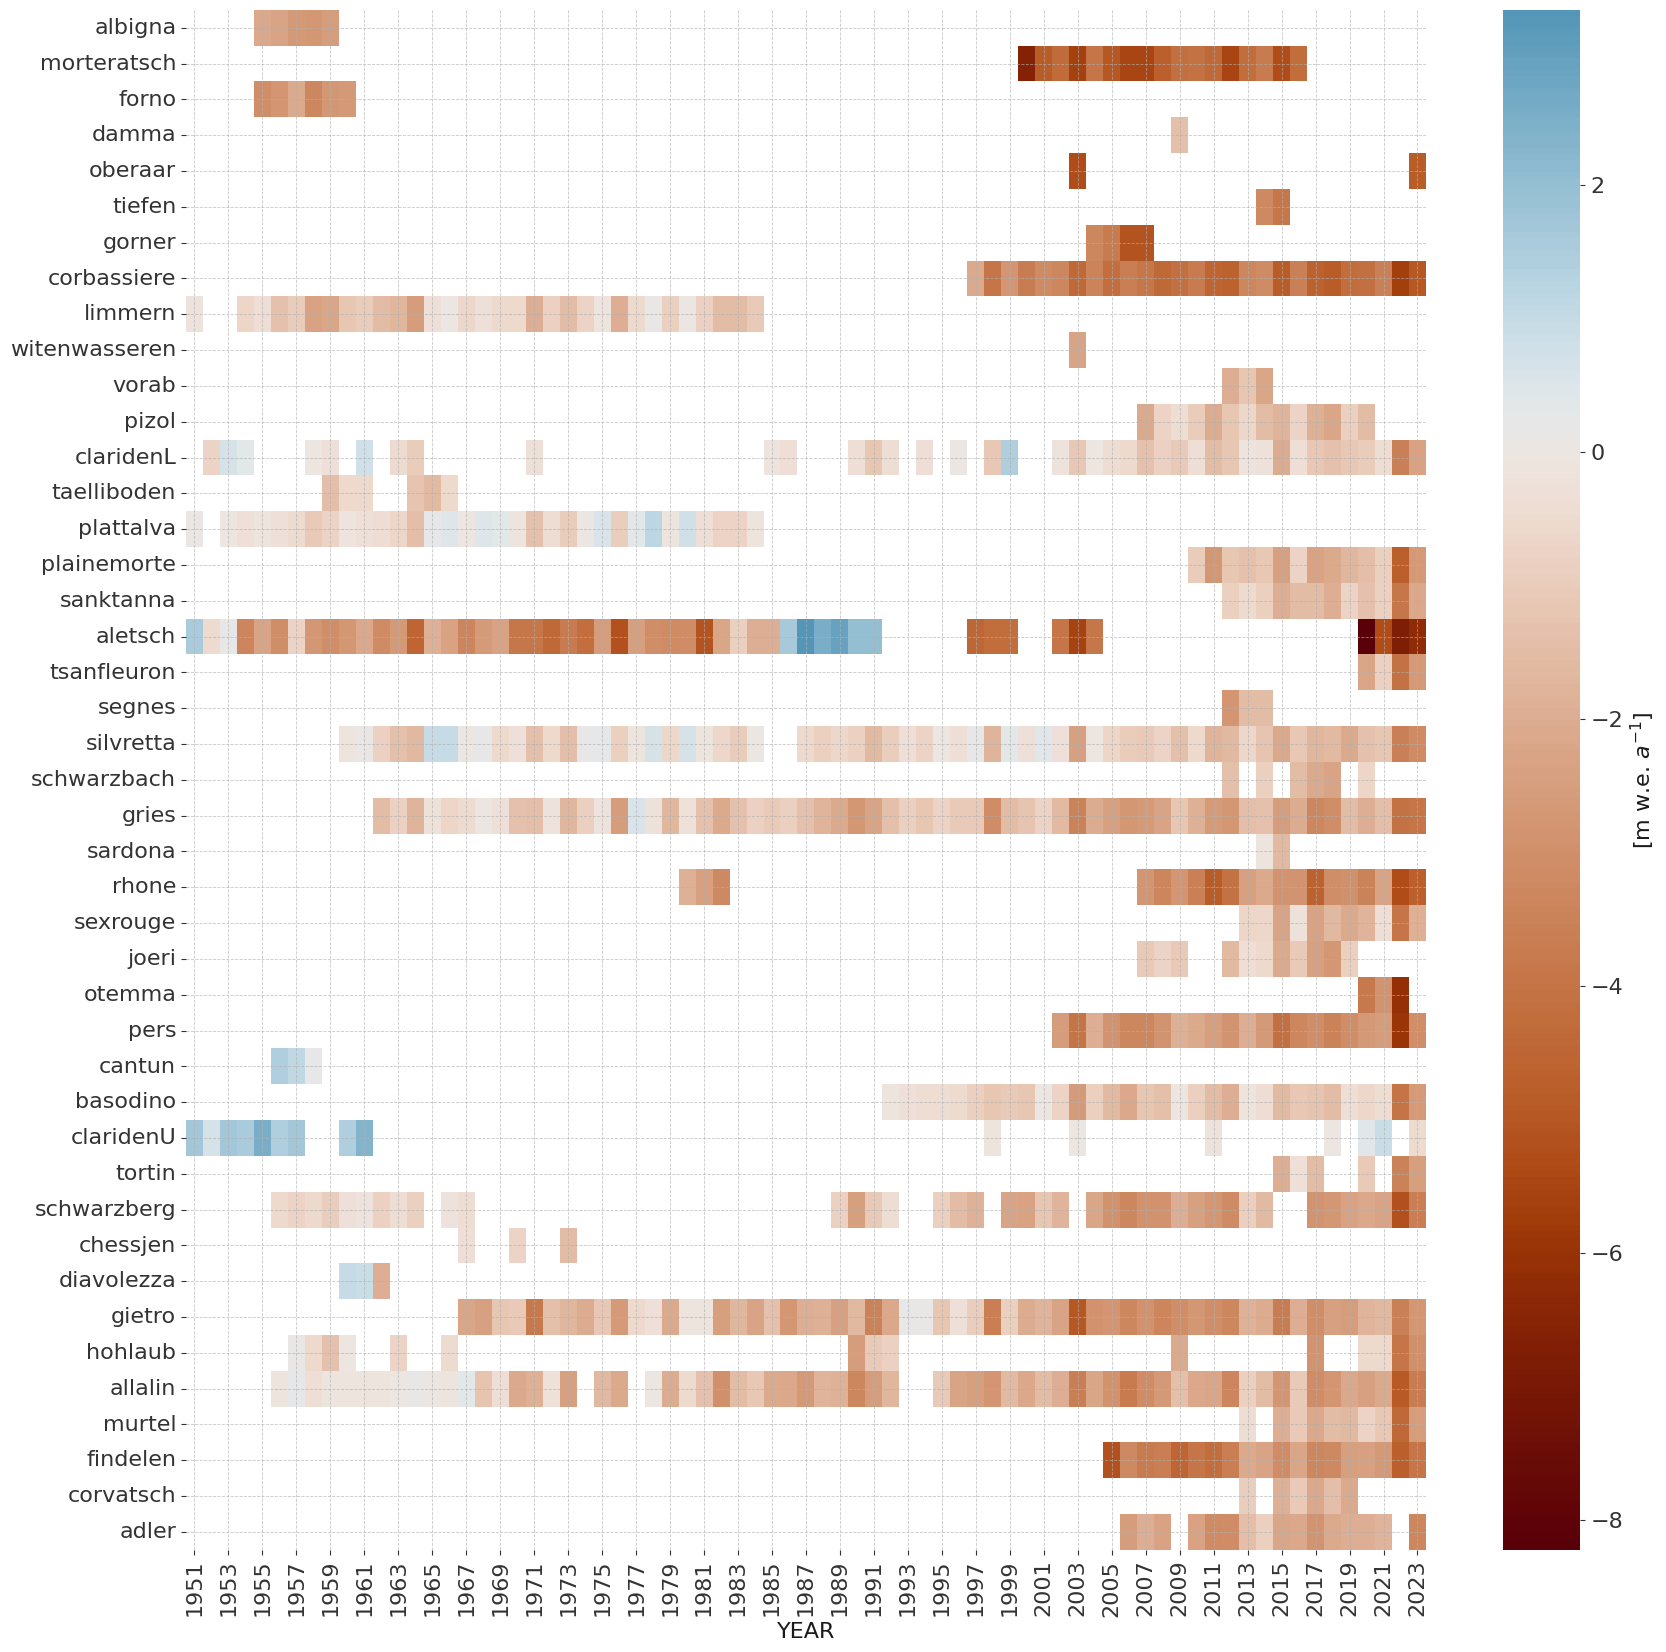

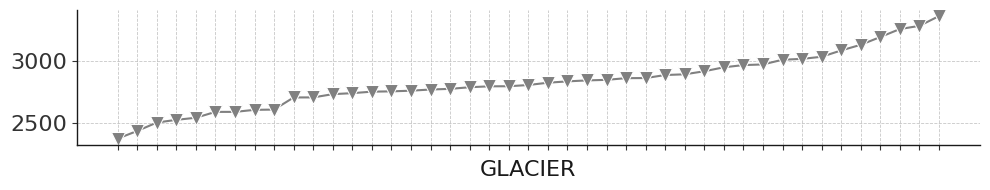

In [6]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier
mean_mb_per_glacier = data_glamos.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] ==
                                          'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_glamos.groupby(['GLACIER'])['POINT_ELEVATION'].mean()

matrix = matrix.loc[gl_per_el.sort_values(ascending=True).index]

# make index categorical
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)
fig = plt.figure(figsize=(20, 20))
ax = plt.subplot(1, 1, 1)
sns.heatmap(data=matrix,
            center=0,
            cmap=cm.vik_r,
            cbar_kws={'label': '[m w.e. $a^{-1}$]'},
            ax=ax)

# Plot elevation:
fig = plt.figure(figsize=(10, 2))
ax = plt.subplot(1, 1, 1)
sns.lineplot(gl_per_el.sort_values(ascending=True),
             ax=ax,
             color='gray',
             marker='v')
ax.set_xticklabels('', rotation=90)
ax.set_ylabel('')
plt.tight_layout()


Text(0.5, 1.0, 'Number of total measurements per glacier since 1961')

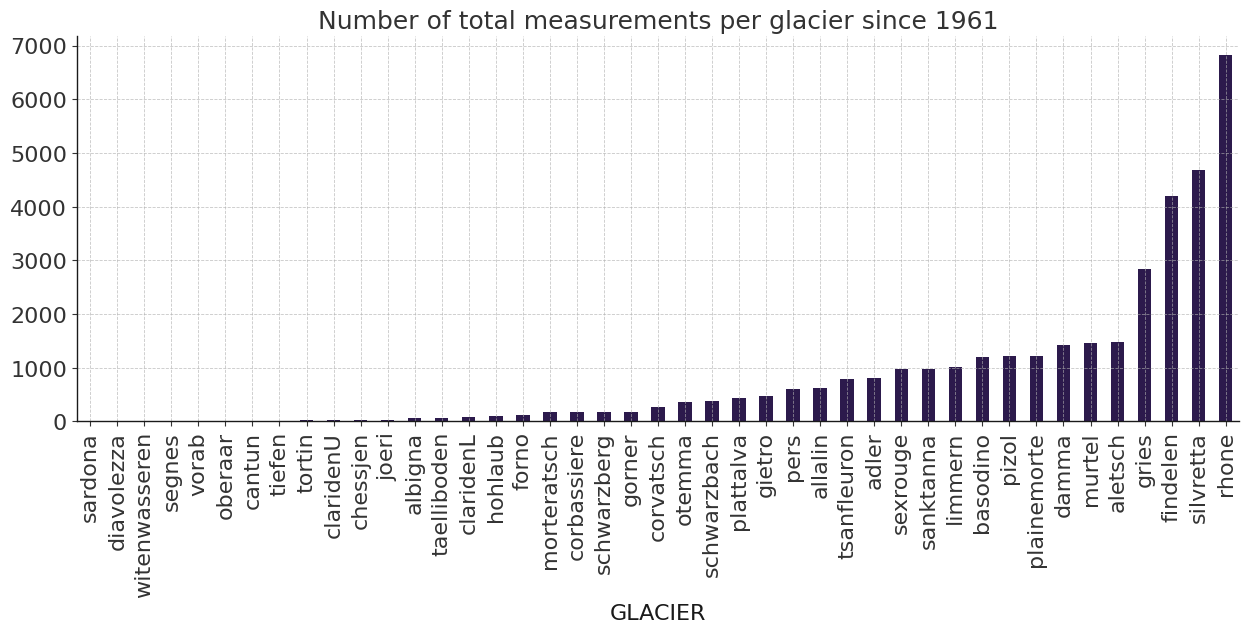

In [7]:
num_gl = data_glamos.groupby(['GLACIER']).size().sort_values()
num_gl.plot(kind='bar', figsize=(15, 5), cmap=cmap)
plt.title('Number of total measurements per glacier since 1961')

### Glaciers with potential radiadation data from GLAMOS:

In [8]:
# Glaciers with data of potential clear sky radiation
# Format to same names as stakes:
glDirect = [
    re.search(r'xr_direct_(.*?)\.nc', f).group(1)
    for f in os.listdir(path_direct_save)
]
glDirect.sort()

restgl = Diff(list(glDirect), list(data_glamos.GLACIER.unique()))
restgl.sort()
print('Glaciers with potential clear sky radiation data:\n', glDirect)
print('Glaciers without potential clear sky radiation data:\n', restgl)

Glaciers with potential clear sky radiation data:
 ['adler', 'albigna', 'aletsch', 'allalin', 'arolla', 'basodino', 'claridenL', 'claridenU', 'corbassiere', 'corvatsch', 'findelen', 'forno', 'gietro', 'gorner', 'gries', 'hohlaub', 'joeri', 'limmern', 'morteratsch', 'murtel', 'oberaar', 'otemma', 'pers', 'pizol', 'plainemorte', 'plattalva', 'rhone', 'sanktanna', 'schwarzbach', 'schwarzberg', 'sexrouge', 'silvretta', 'taelliboden', 'tortin', 'tsanfleuron']
Glaciers without potential clear sky radiation data:
 ['arolla', 'cantun', 'chessjen', 'damma', 'diavolezza', 'sardona', 'segnes', 'tiefen', 'vorab', 'witenwasseren']


In [9]:
xr.open_dataset(path_ERA5_raw + 'era5_monthly_averaged_data.nc')

<xarray.Dataset> Size: 2GB
Dimensions:    (longitude: 201, latitude: 51, expver: 2, time: 895)
Coordinates:
  * longitude  (longitude) float32 804B 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9 20.0
  * latitude   (latitude) float32 204B 50.0 49.9 49.8 49.7 ... 45.2 45.1 45.0
  * expver     (expver) int32 8B 1 5
  * time       (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-07-01
Data variables: (12/14)
    u10        (time, expver, latitude, longitude) float64 147MB ...
    v10        (time, expver, latitude, longitude) float64 147MB ...
    t2m        (time, expver, latitude, longitude) float64 147MB ...
    fal        (time, expver, latitude, longitude) float64 147MB ...
    snowc      (time, expver, latitude, longitude) float64 147MB ...
    rsn        (time, expver, latitude, longitude) float64 147MB ...
    ...         ...
    smlt       (time, expver, latitude, longitude) float64 147MB ...
    slhf       (time, expver, latitude, longitude) float64 147MB ...
    str        (time, expver, latitude, longitude) float64 147MB ...
    sshf       (time, expver, latitude, longitude) float64 147MB ...
    ssrd       (time, expver, latitude, longitude) float64 147MB ...
    tp         (time, expver, latitude, longitude) float64 147MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-08 11:30:10 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

## Data:
### Input dataset:

In [10]:
RUN = False
if RUN:
    # Filter data_glamos
    data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
    print('Running on {} glaciers:\n {}'.format(
        len(data_glamos.GLACIER.unique()), data_glamos.GLACIER.unique()))
    # Create dataloader:
    dataset_gl = mbm.Dataset(data=data_glamos,
                             region_name='CH',
                             data_path=path_PMB_GLAMOS_csv)
    print('Number of winter and annual samples:', len(data_glamos))
    print('Number of annual samples:',
          len(data_glamos[data_glamos.PERIOD == 'annual']))
    print('Number of winter samples:',
          len(data_glamos[data_glamos.PERIOD == 'winter']))

    # Add climate data:
    # Specify the files of the climate data, that will be matched with the coordinates of the stake data
    era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
    geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

    # Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
    dataset_gl.get_climate_features(climate_data=era5_climate_data,
                                    geopotential_data=geopotential_data,
                                    change_units=True)

    # Add potential clear sky radiation:
    print('----------------------\nAdding potential clear sky radiation:')
    print('Shape before pot rad:', dataset_gl.data.shape)
    dataset_gl.get_potential_rad(path_direct_save)
    print('Shape after pot rad:', dataset_gl.data.shape)

    print('----------------------\nConverting to monthly resolution:')
    # For each record, convert to a monthly time resolution
    dataset_gl.convert_to_monthly(meta_data_columns=config.META_DATA,
                                  vois_climate=vois_climate + ['pcsr'],
                                  vois_topographical=vois_topographical)

    # Create a new DataLoader object with the monthly stake data measurements.
    dataloader_gl = mbm.DataLoader(data=dataset_gl.data,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)

    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Columns in the dataset:', dataloader_gl.data.columns)

    # save the data
    dataloader_gl.data.to_csv(path_PMB_GLAMOS_csv +
                              'CH_wgms_dataset_monthly_full.csv',
                              index=False)
else:
    # read data
    data_monthly = pd.read_csv(path_PMB_GLAMOS_csv +
                               'CH_wgms_dataset_monthly_full.csv')
    dataloader_gl = mbm.DataLoader(data=data_monthly,
                                   random_seed=config.SEED,
                                   meta_data_columns=config.META_DATA)
    print('Number of monthly rows:', len(dataloader_gl.data))
    print('Number of annual rows:', len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
    print('Number of winter rows:', len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Number of monthly rows: 300905
Number of annual rows: 102252
Number of winter rows: 198653


### Balancing data:

#### Oversampling:

### Feature correlation:

<Axes: >

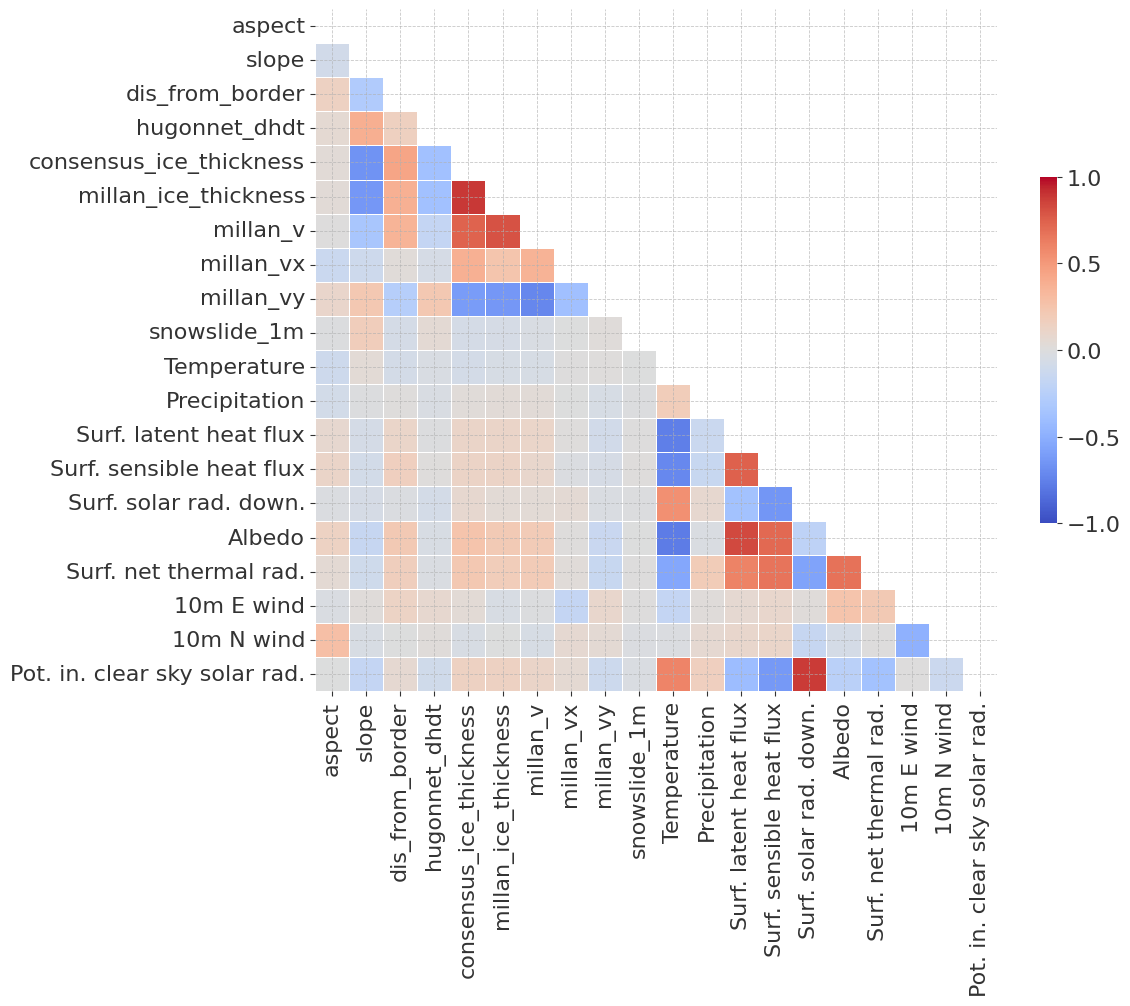

In [11]:
# Intercorrelation between features:
df = dataloader_gl.data.copy()
df = df.dropna()
df = df.drop(columns=[
    'GLACIER',
    'PERIOD',
    'YEAR',
    'POINT_LON',
    'POINT_LAT',
    'POINT_BALANCE',
    'ALTITUDE_CLIMATE',
    'ELEVATION_DIFFERENCE',
    'POINT_ELEVATION',
    'RGIId',
    'POINT_ID',
    'ID',
    'N_MONTHS',
    'MONTHS',
])
# rename voi climate to long name
df.rename(columns=vois_climate_long_name,
          inplace=True)

corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# plot
sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            vmax=1,
            vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

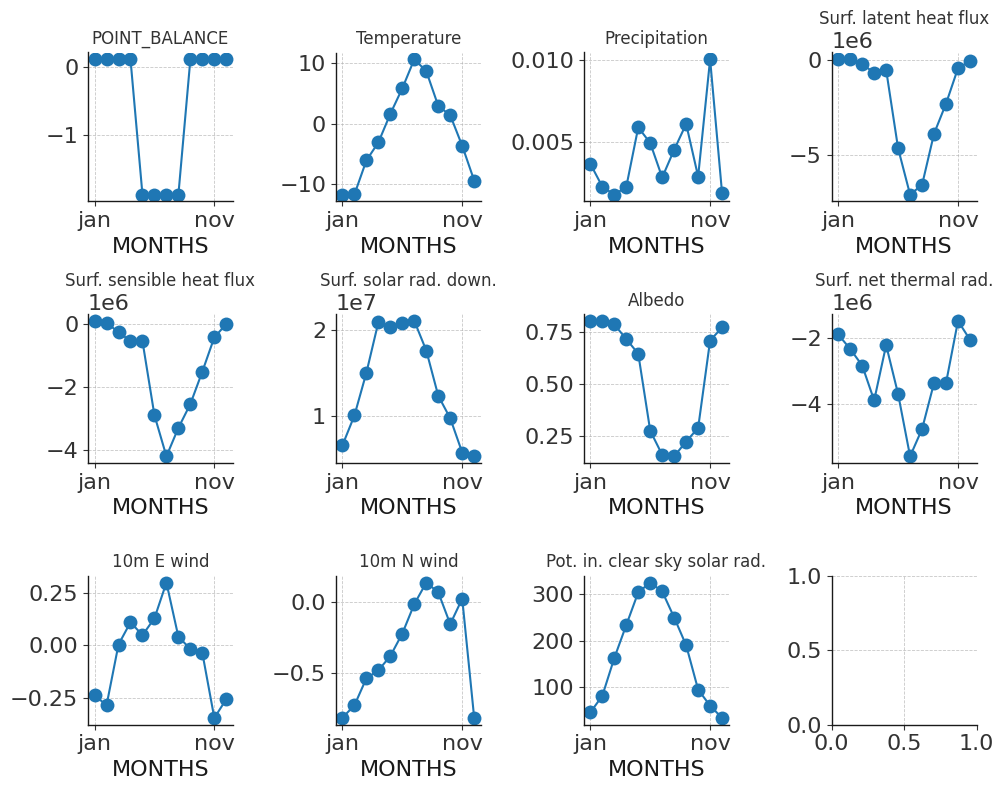

In [12]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate + ['pcsr']
df = df[(df.GLACIER == 'corvatsch') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

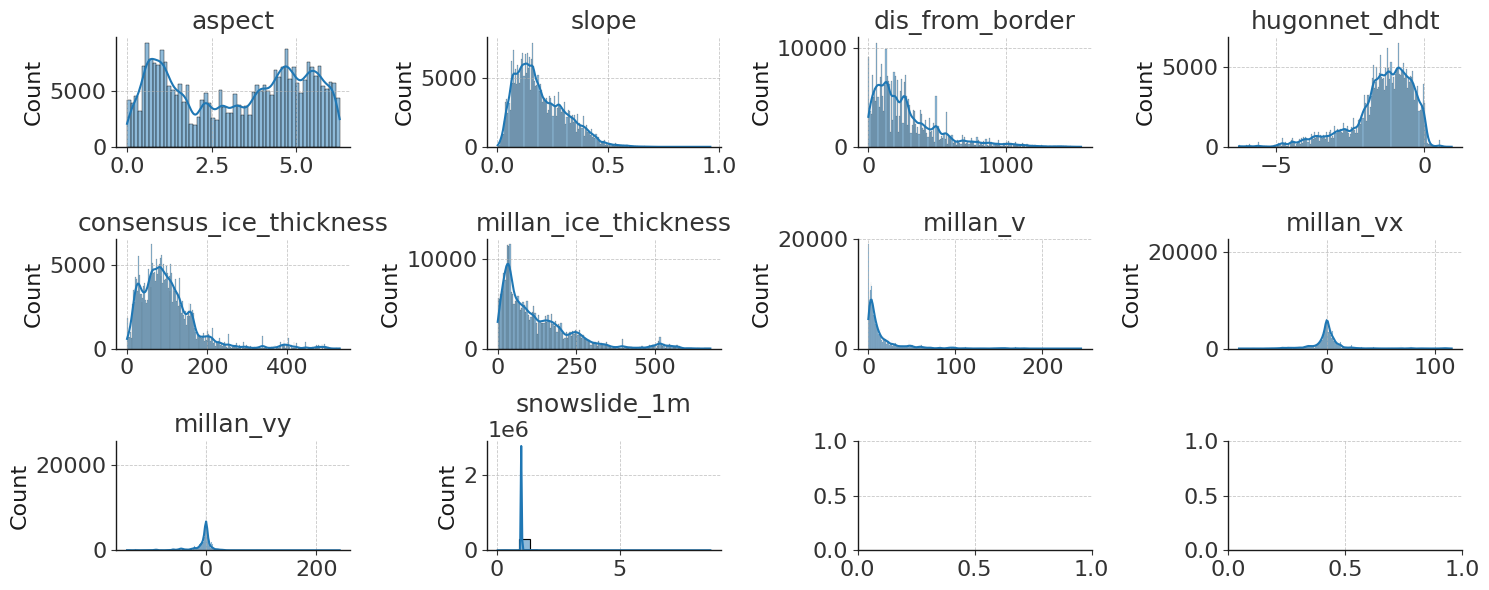

In [13]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 4, figsize=(15, 6))
for i, var in enumerate(vois_topographical):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### Blocking on glaciers:

In [14]:
# test_glaciers = [
#     'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'rhone'
# ]
test_glaciers = [
    'tortin', 'plattalva', 'sanktanna', 'schwarzberg', 'hohlaub', 'pizol',
    'joeri', 'corvatsch', 'tsanfleuron'
]
train_glaciers = [
    i for i in dataloader_gl.data.GLACIER.unique() if i not in test_glaciers
]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(train_glaciers)]
print('Size of train data:', len(data_train))

test_perc = (len(data_test) / len(data_train)) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))

Size of test data: 32974
Size of train data: 267931
Percentage of test size: 12.31%


In [15]:
# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:',
      len(data_test[data_test.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_test[data_test.PERIOD == 'winter']))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:', len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:', len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Train:
Number of winter and annual samples: 267931
Number of annual samples: 93332
Number of winter samples: 174599
Test:
Number of winter and annual samples: 32974
Number of annual samples: 8920
Number of winter samples: 24054
Total:
Number of monthly rows: 300905
Number of annual rows: 102252
Number of winter rows: 198653


#### Heatmap annual:

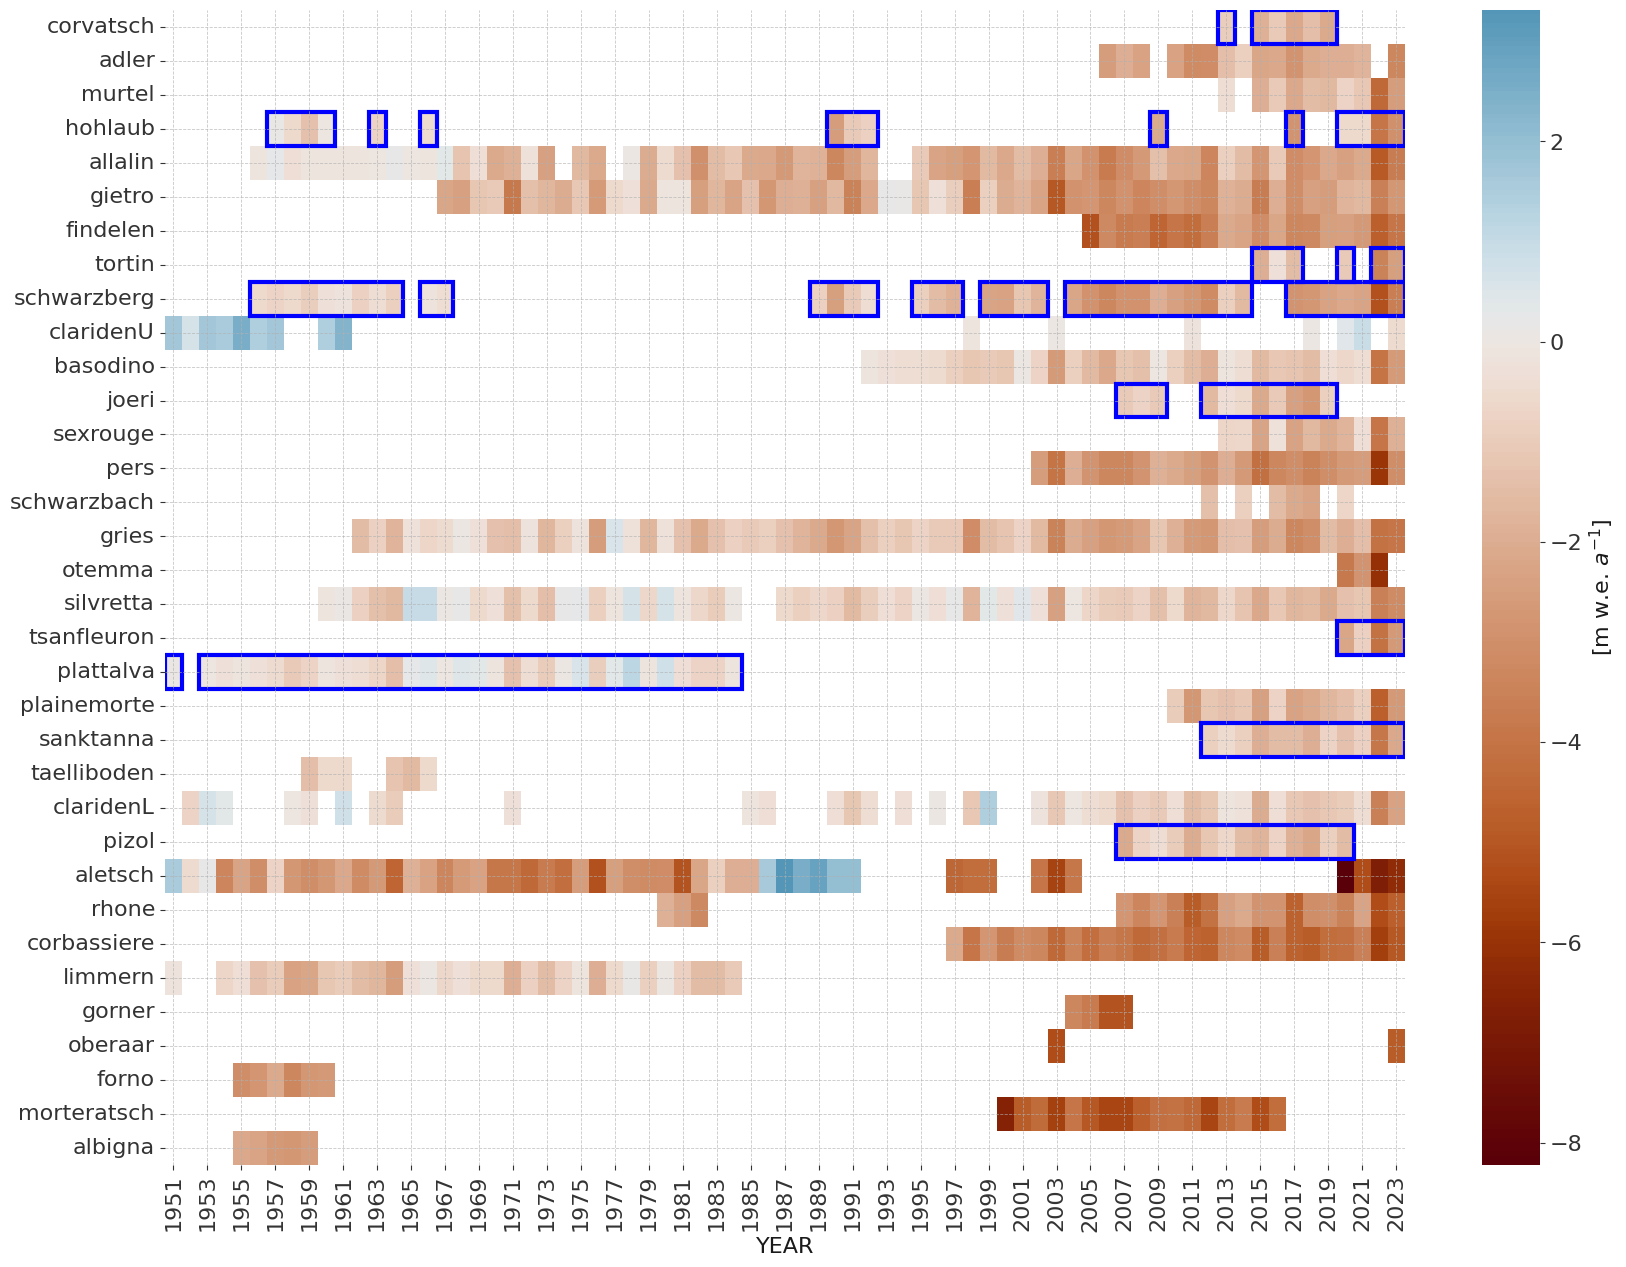

In [16]:
plotHeatmap(test_glaciers, data_glamos, glDirect, period='annual')

#### Heatmap winter:

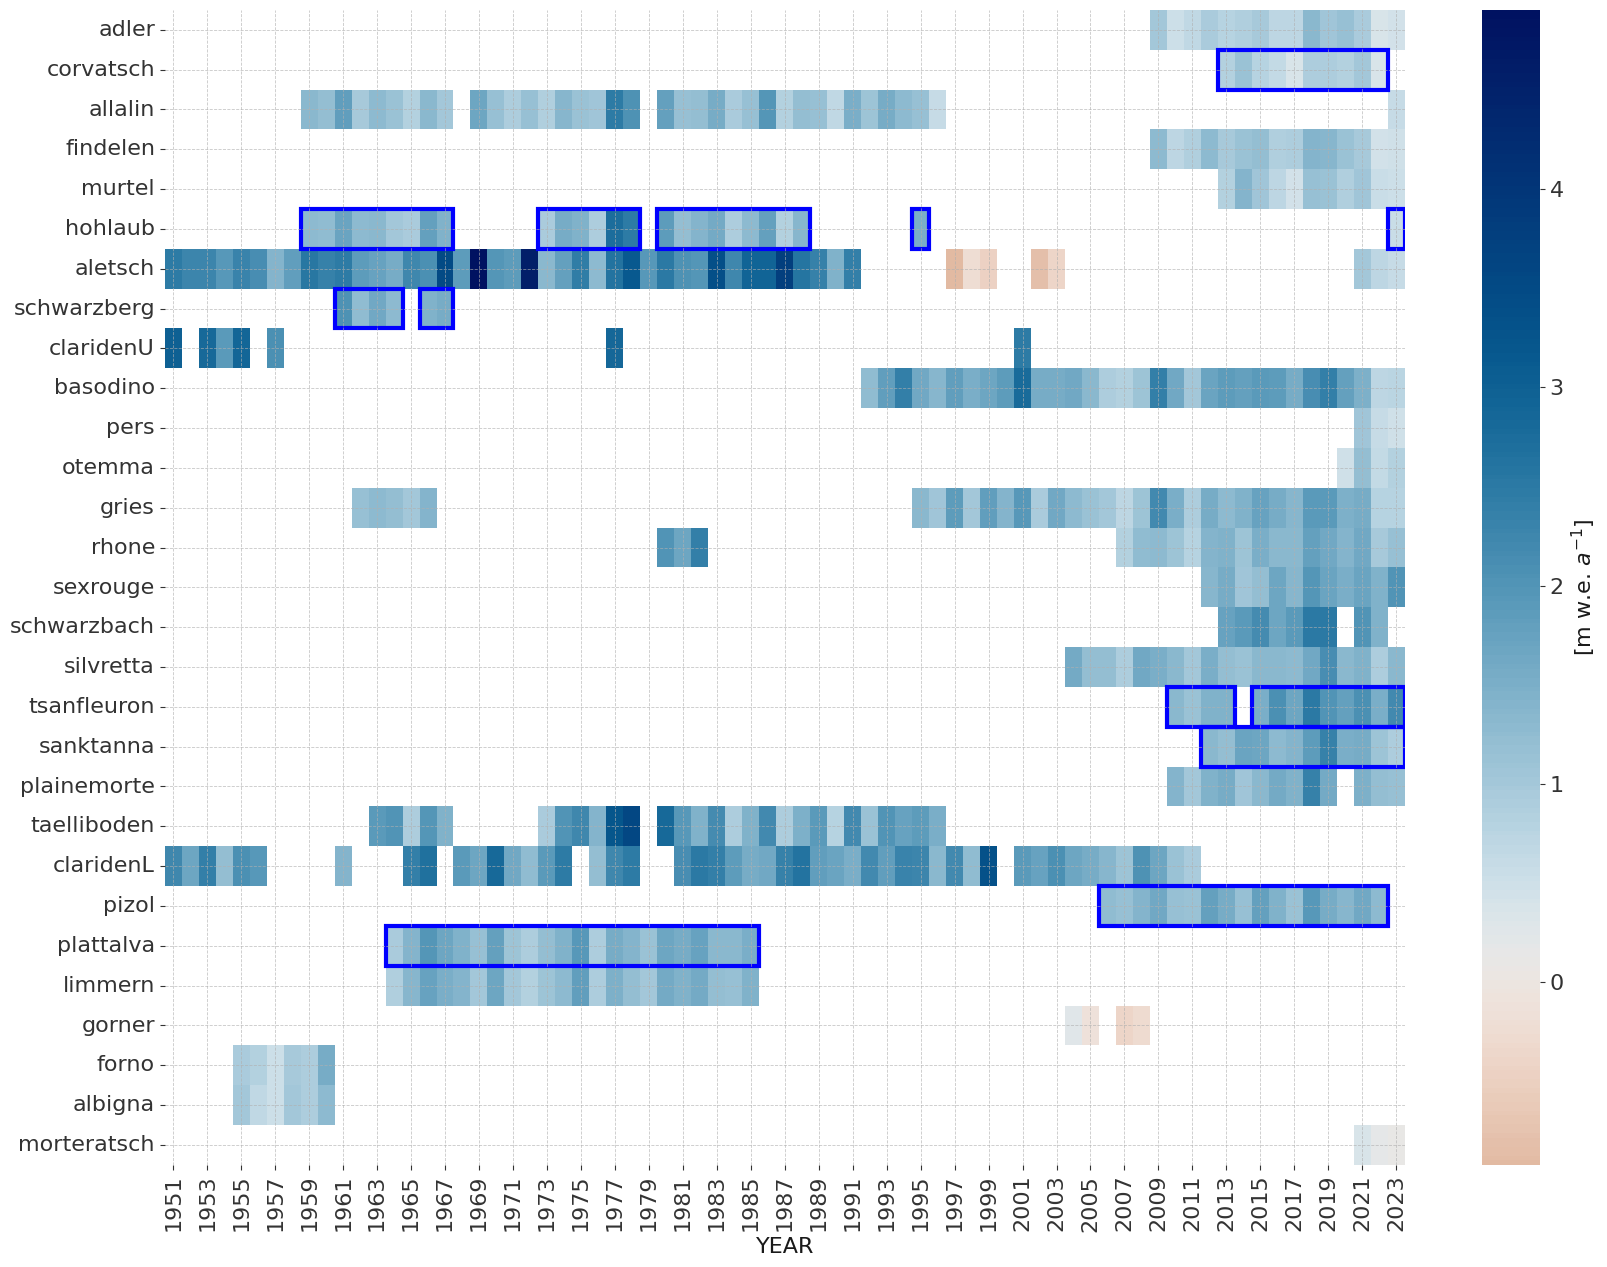

In [17]:
plotHeatmap(test_glaciers, data_glamos, glDirect, period='winter')

#### CV splits:

Test glaciers: (9) ['corvatsch' 'hohlaub' 'joeri' 'pizol' 'plattalva' 'sanktanna'
 'schwarzberg' 'tortin' 'tsanfleuron']
Percentage of test size: 12.31%
Size of test set: 32974
Train glaciers: (25) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'claridenL' 'claridenU'
 'corbassiere' 'findelen' 'forno' 'gietro' 'gorner' 'gries' 'limmern'
 'morteratsch' 'murtel' 'oberaar' 'otemma' 'pers' 'plainemorte' 'rhone'
 'schwarzbach' 'sexrouge' 'silvretta' 'taelliboden']
Size of train set: 267931


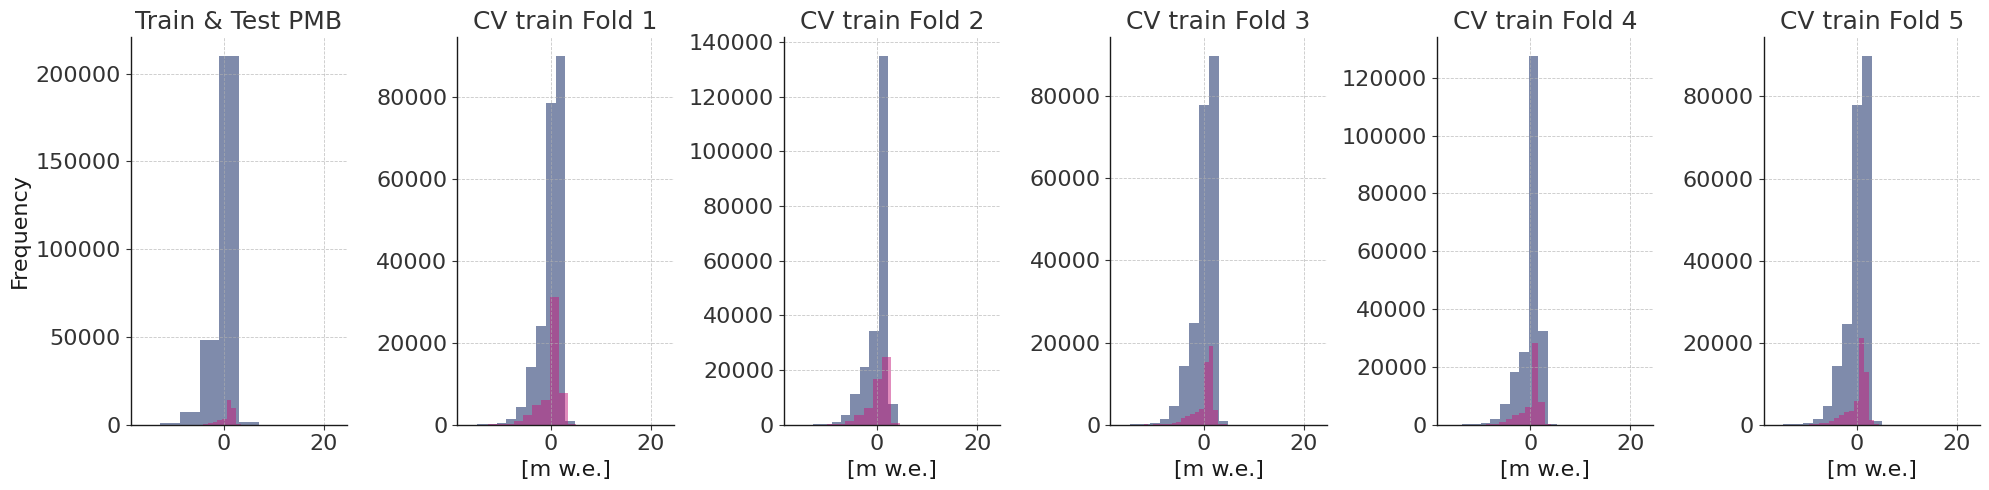

In [18]:
splits, test_set, train_set = getCVSplits(dataloader_gl,
                                          test_split_on='GLACIER',
                                          test_splits=test_glaciers)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))
visualiseSplits(test_set['y'], train_set['y'], splits)


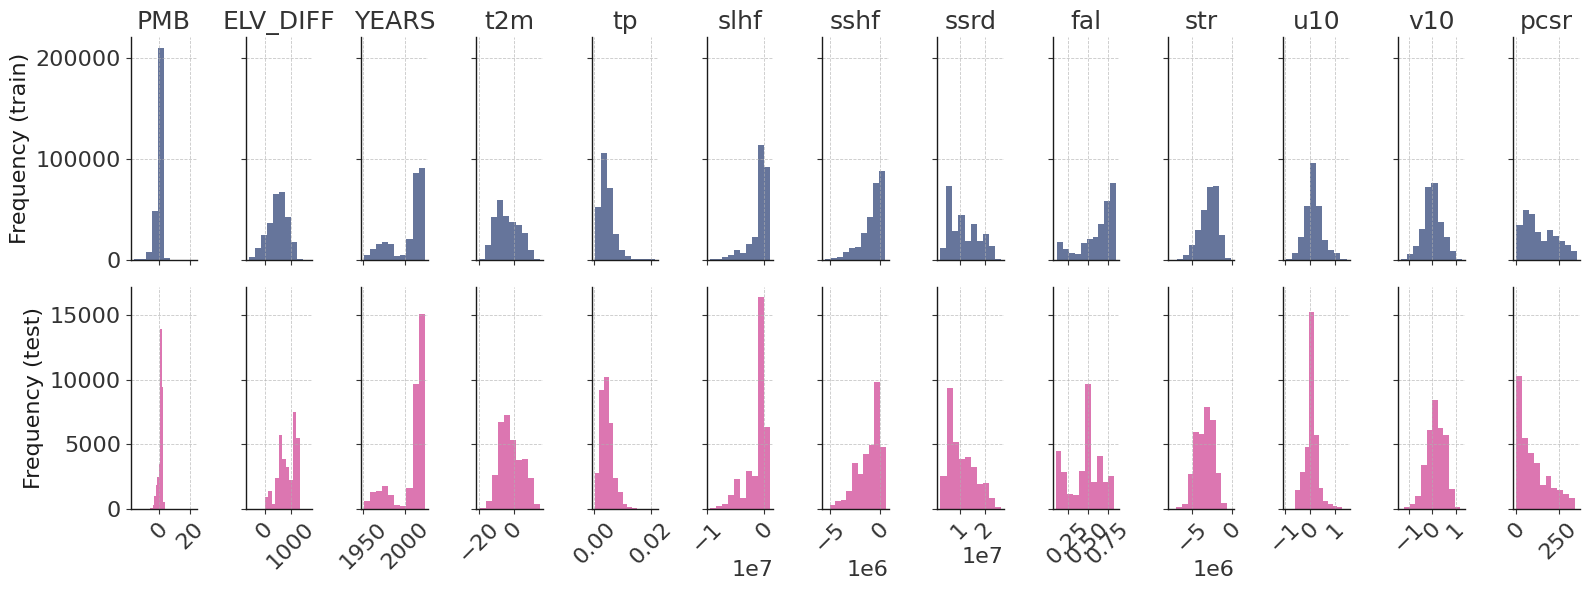

In [19]:
visualiseInputs(train_set, test_set, vois_climate)

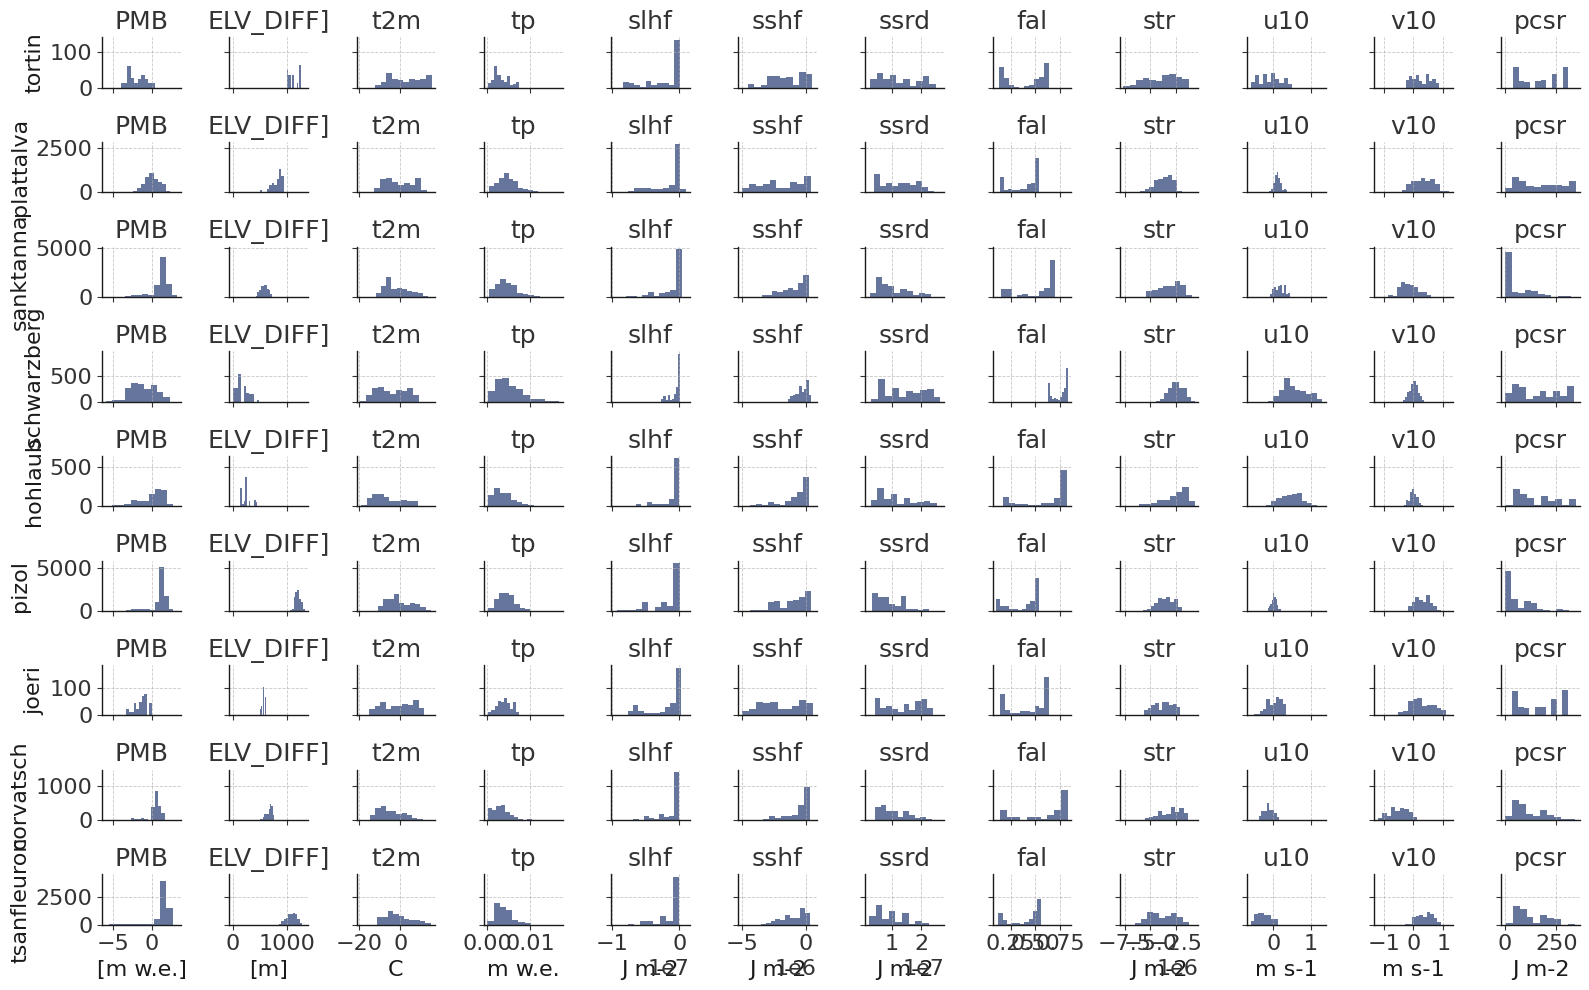

In [20]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_xgb,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_xgb,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate + ['pcsr']):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_xgb,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

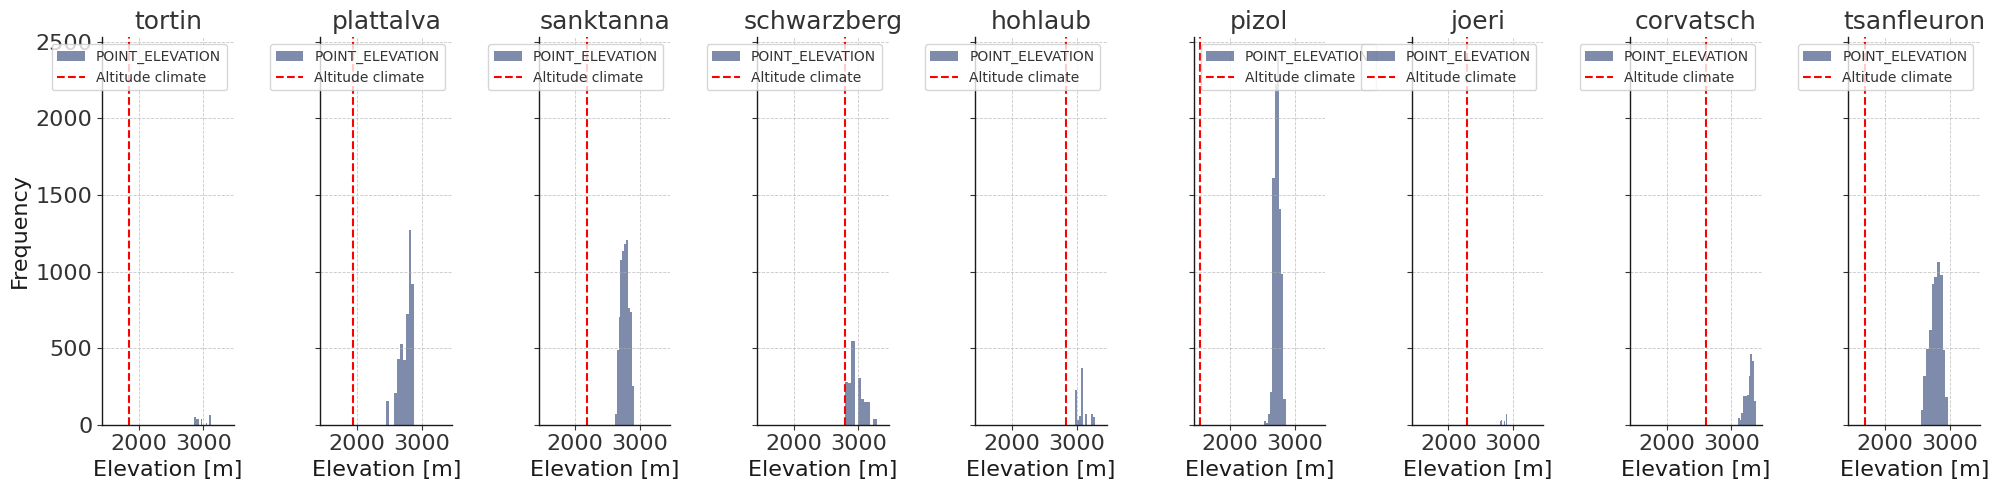

In [21]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_xgb,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

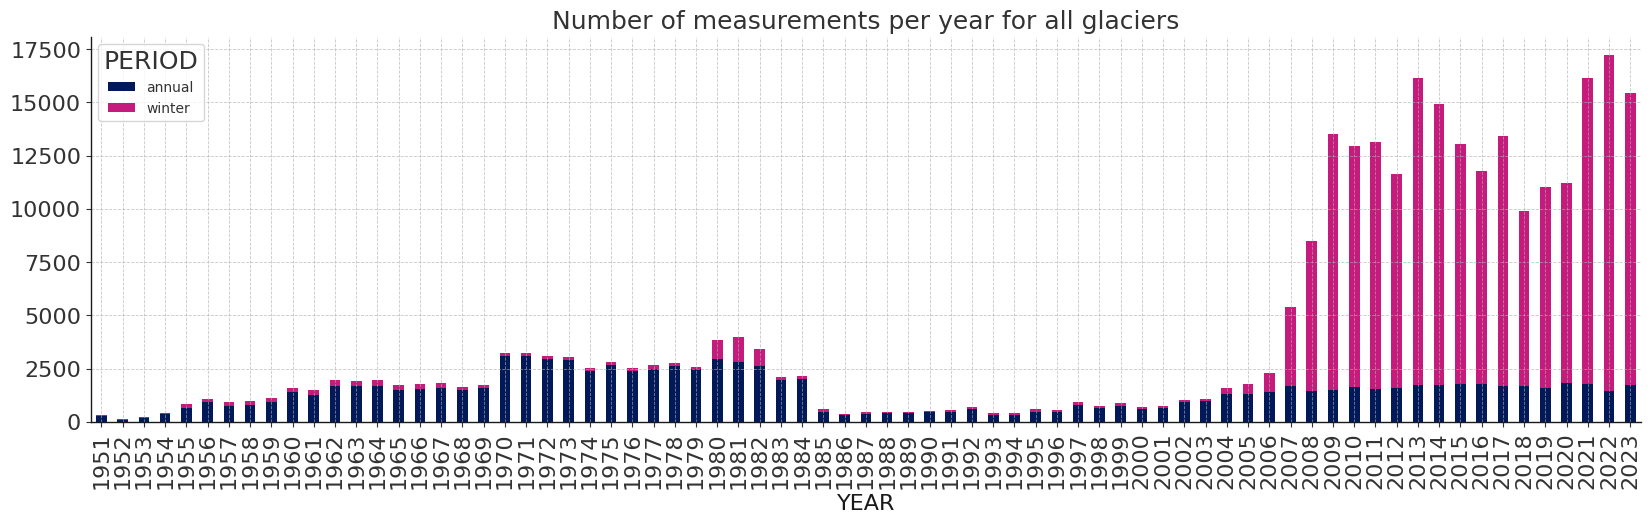

In [22]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD'
                     ]).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              figsize=(20, 5),
                                              color=[color_xgb, color_tim])
plt.title('Number of measurements per year for all glaciers')

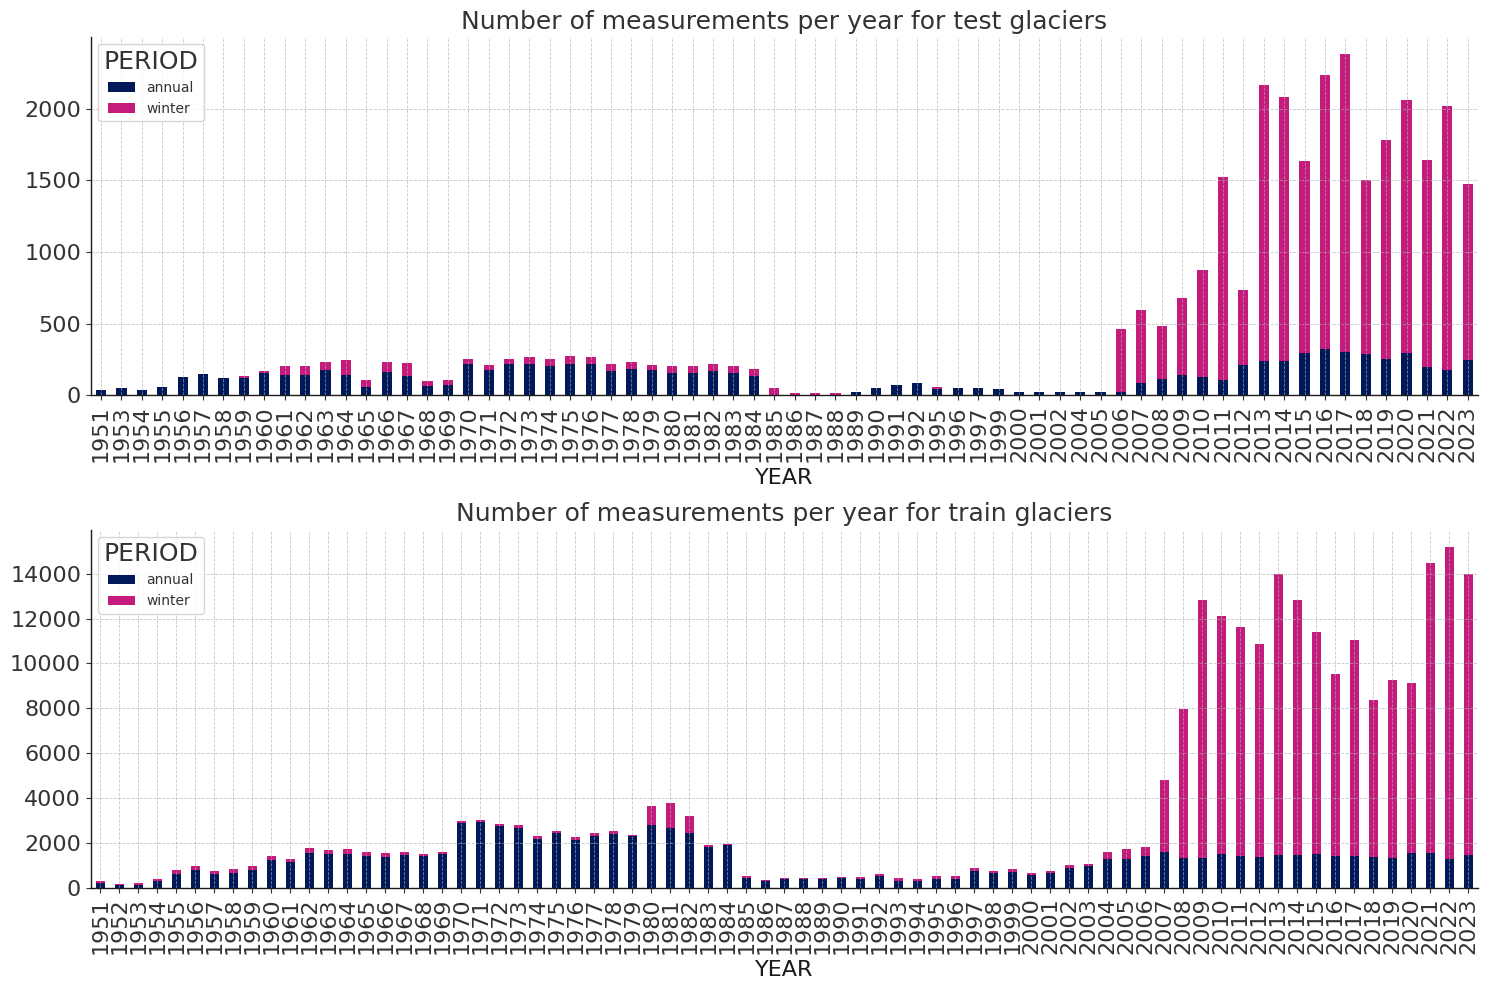

In [23]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD'
                   ]).size().unstack().plot(kind='bar',
                                            stacked=True,
                                            color=[color_xgb, color_tim],
                                            ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD'
                    ]).size().unstack().plot(kind='bar',
                                             stacked=True,
                                             color=[color_xgb, color_tim],
                                             ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## Model:

### Parameters of grid search:

In [24]:
# Grid search
# For each of the XGBoost parameter, define the grid range
# param_grid = {
#     'max_depth': [
#         3,
#         4,
#         5,
#         6,
#     ],
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [100, 200, 300],
#     'gamma': [0, 1]
# }
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = config.SEED
param_init["n_jobs"] = config.NUM_JOBS

In [38]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(**param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # custom_xgboost.gridsearch(
    #     parameters=param_grid,
    #     splits=splits,
    #     features=df_X_train_subset,
    #     targets=train_set['y'],
    # )

    # save best model
    custom_xgboost.save_model(f'xgb_gl_split_full_probes.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor()
    custom_xgboost.load_model(f'xgb_gl_split_full_probes.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))


Shape of training dataset: (267931, 32)
Shape of testing dataset: (32974, 32)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'dis_from_border', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_ice_thickness', 'millan_v', 'millan_vx', 'millan_vy', 'snowslide_1m', 'pcsr']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


KeyboardInterrupt: 

In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

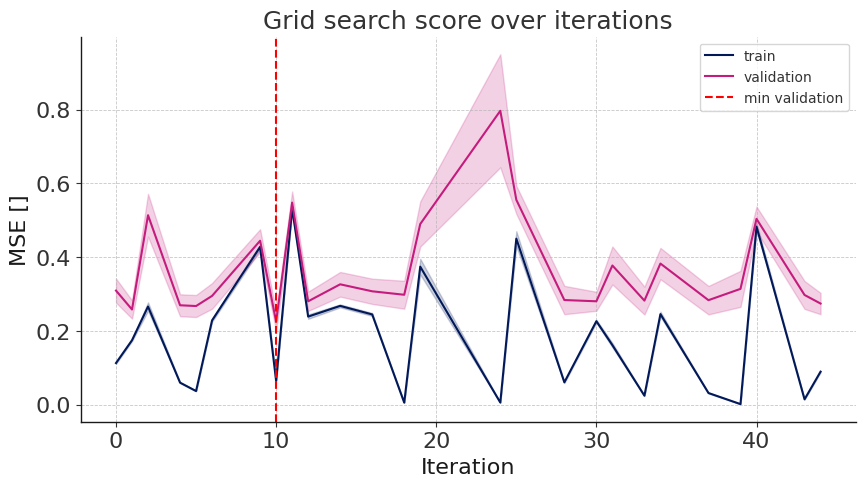

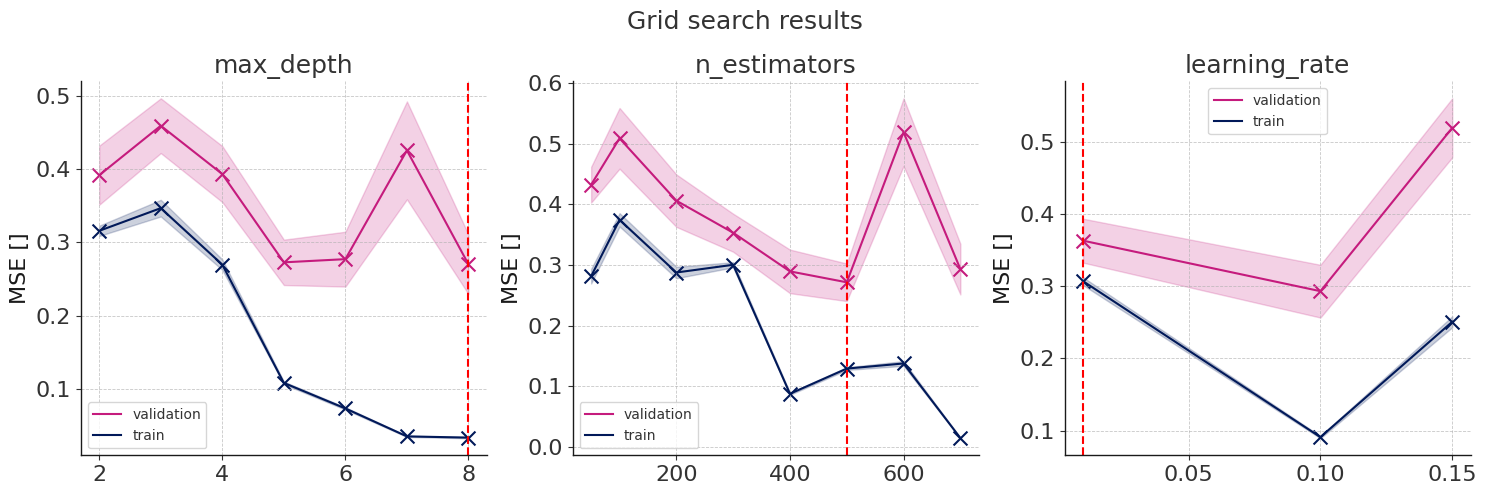

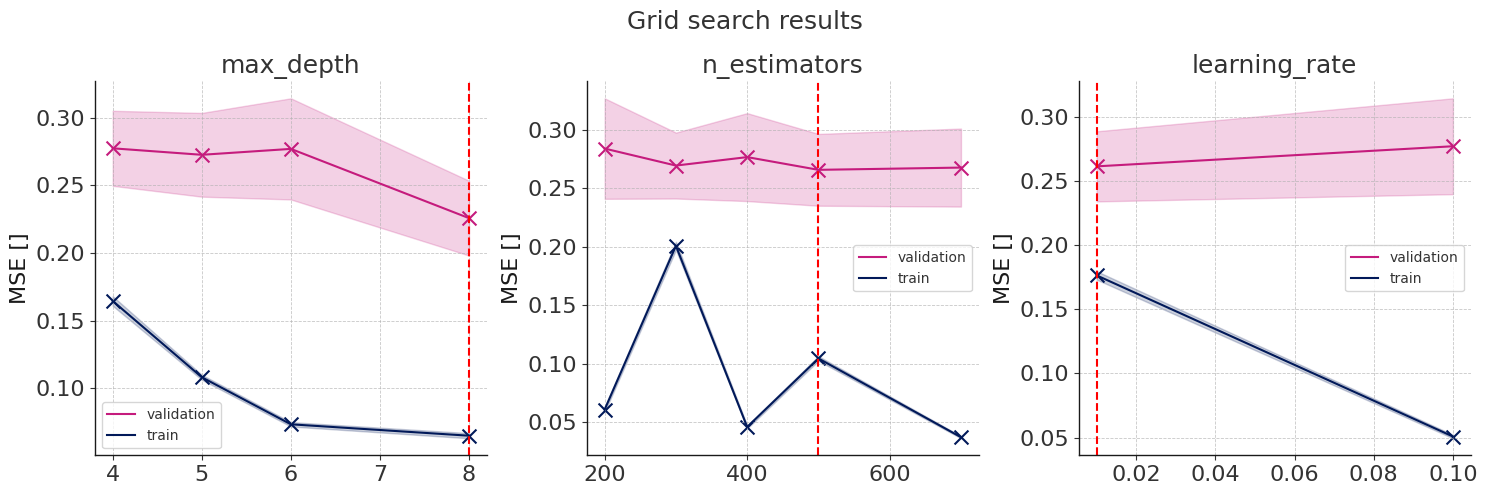

In [36]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid)
plotGridSearchParams(custom_xgboost.param_search.cv_results_, param_grid, N=10)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

##### Predictions of best parameters:

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, config.META_DATA,
                                            features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()


##### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
all_columns = feature_columns + config.META_DATA + config.NOT_METADATA_NOT_FEATURES
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(**params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])
custom_model = custom_model.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns], config.META_DATA)
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, config.META_DATA,
                                      features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPred(grouped_ids, figsize=(15, 30))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Cross-checks:

### Monthly predictions:

In [ ]:
df_metadata = pd.DataFrame(metadata_test, columns=config.META_DATA)
df_metadata = df_metadata.assign(y_pred=y_pred)

# separate into annual and winter
dfpred_annual = df_metadata[df_metadata['PERIOD'] == 'annual']
dfpred_winter = df_metadata[df_metadata['PERIOD'] == 'winter']

# plot distribution of predictions per month, one plot per month
f, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True)
for i, month in enumerate(month_abbr[1:]):
    dfpred_annual[dfpred_annual['MONTHS'] == month.lower()].y_pred.plot.hist(
        ax=ax.flatten()[i],
        color=color_xgb,
        alpha=0.6,
        density=False,
        label='annual')
    if month.lower() in dfpred_winter.MONTHS.unique():
        dfpred_winter[dfpred_winter['MONTHS'] ==
                      month.lower()].y_pred.plot.hist(ax=ax.flatten()[i],
                                                      color=color_tim,
                                                      alpha=0.6,
                                                      density=False,
                                                      label='winter')
    ax.flatten()[i].set_title(month, fontsize=24)
    ax.flatten()[i].set_xlabel('[m w.e.]', fontsize=20)
    ax.flatten()[i].legend(fontsize=16)
    # add vertical line for 0 balance
    ax.flatten()[i].axvline(x=0, color='black', linestyle='--')
plt.tight_layout()

### 2D fields:


#### Corvatsch:

In [ ]:
# Make glacier wide predictions for one test glacier:
glacierName = 'corvatsch'

rgi_gl = rgi_df.loc[glacierName]['rgi_id.v6']
data_gl = data_glamos[data_glamos.RGIId == rgi_gl]
dataset_gl = mbm.Dataset(data=data_gl,
                         region_name='CH',
                         data_path=path_PMB_GLAMOS_csv)
ds, glacier_indices, gdir = dataset_gl.get_glacier_mask(custom_working_dir)

# Create pandas dataframe of glacier grid
years = data_gl['YEAR'].unique()
df_grid_annual = dataset_gl.create_glacier_grid(custom_working_dir)
# Add metadata that is not in WGMS dataset
df_grid_annual["PERIOD"] = "annual"
df_grid_annual['GLACIER'] = glacierName

# Load monthly glacier grid (preprocessed in other notebooks)
df_grid_monthly = pd.read_csv(path_glacier_grid + f'{glacierName}_grid.csv')
dataloader = mbm.DataLoader(data=df_grid_monthly,
                            meta_data_columns=config.META_DATA)
print('\nNumber of years: {}, from {} to {}'.format(len(years), years[0],
                                                    years[-1]))
print('\nNumber of total (yearly) measurements:', len(df_grid_annual))

# get years with stake measurements:
years_stakes = data_gl['YEAR'].unique()
print('Years with stake measurements:', years_stakes)

# Plot glacier attributes of oggm:
plotGlAttr(ds, cmap=cm.devon)

# Plot glacier grid with stakes:
plotGlGrid(df_grid_annual, data_gl)

##### Annual and winter predictions:

In [ ]:
grouped_ids_annual = GlacierWidePred(custom_model,
                                     glacierName,
                                     vois_climate,
                                     vois_topographical,
                                     type_pred='annual')
grouped_ids_winter = GlacierWidePred(custom_model,
                                     glacierName,
                                     vois_climate,
                                     vois_topographical,
                                     type_pred='winter')

In [ ]:
# Sum over all points of a glacier to get glacier wide SMB
grouped_ids_annual_glw = grouped_ids_annual.groupby('YEAR').mean()

# Compare to GLAMOS data:
df_glamos = pd.read_csv(path_SMB_GLAMOS_csv + 'fix/' +
                        f'{glacierName}_fix.csv')
df_glamos = transformDates(df_glamos)

# Remove obvious duplicates:
df_glamos = df_glamos.drop_duplicates()
df_glamos['YEAR'] = df_glamos['date1'].apply(lambda x: pd.to_datetime(x).year)
df_glamos['Annual Balance'] = df_glamos['Annual Balance'] / (1000)
df_glamos = df_glamos[['YEAR', 'Annual Balance']].set_index('YEAR')

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
grouped_ids_annual_glw.plot(y='pred',
                            label='Predicted SMB',
                            ax=ax,
                            color=color_xgb)
df_glamos[df_glamos.index > 1960].plot(y='Annual Balance',
                                       label='GLAMOS SMB',
                                       ax=ax,
                                       color=color_tim)

ax.set_title(f'{glacierName.title()} SMB')
ax.set_ylabel('SMB (m w.e.)')
plt.tight_layout()

In [ ]:
TwoDPlotsAllYears(grouped_ids_annual,
                  grouped_ids_winter,
                  years_stakes,
                  figsize=(10, 25))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
TwoDPlots(glacierName, grouped_ids_annual, grouped_ids_winter,
          years_stakes[-1], axs)